I shld maybe change `pdfs.py` to `distributions.py`, and include functions:

`signal_cdf`, `background_cdf`, `total_cdf`

In [1]:
true_params = {'f': 0.1, 'lam': 0.5, 'mu': 5.28, 'sigma': 0.018}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL, BinnedNLL
from scipy.stats import norm, expon
from time import process_time

# import function to generate data
from generation import generate_from_total_pdf

# generate 100000 events
N_events= 100000
dataset = generate_from_total_pdf(N_events, f=0.1, lam=0.5, mu=5.28, sigma=0.018, alpha=5, beta=5.6)


Generated 100000 events in 0.002666s


In [1]:
# import sys 
# sys.path.append('/Users/willknott/Desktop/DIS/coursework/pds/wdk24/src')

In [3]:
from distributions import total_model as model

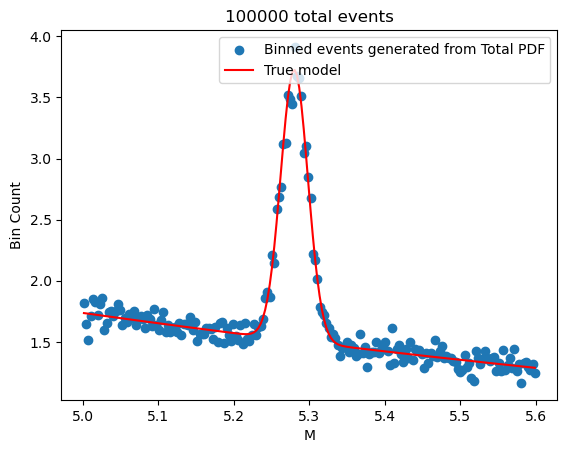

In [5]:
# Bin the events
bins = 200
bin_counts, bin_edges = np.histogram(dataset, bins=bins, density=True)

# Calculate bin midpoints
midpoints = 0.5 * (bin_edges[:-1] + bin_edges[1:])

fig, ax = plt.subplots()

# Plotting bin count vs midpoints
ax.scatter(midpoints, bin_counts, label='Binned events generated from Total PDF', marker='o')
ax.plot(midpoints, model(midpoints, **true_params), label='True model', color='red')

ax.set_xlabel('M')
ax.set_ylabel('Bin Count')
ax.set_title(f'{N_events} total events')

ax.legend()

# iminuit

This page explains the estimated uncertainty of the parameter estimates, by using the Hesse algorithm, and the Minos algorithm

https://iminuit.readthedocs.io/en/stable/notebooks/hesse_and_minos.html



In [6]:
# (unbinned) negative log likelihood as the cost function
unbinned_nll = UnbinnedNLL(dataset , model)

# Minimisation object
# Passing random starting values for the parameters
alpha, beta = 5, 5.6
mi = Minuit(
    fcn = unbinned_nll,
    f = 0.1,
    lam = 0.5,
    mu = 5.28,
    sigma = 0.018,
)

# Minimise the cost function
mi.migrad()

# Hesse algorithm
mi.hesse()

# Minos algorithm
mi.minos()

# print the fit result
print(mi)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.095e+05                 │              Nfcn = 242              │
│ EDM = 9.21e-06 (Goal: 0.0002)    │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

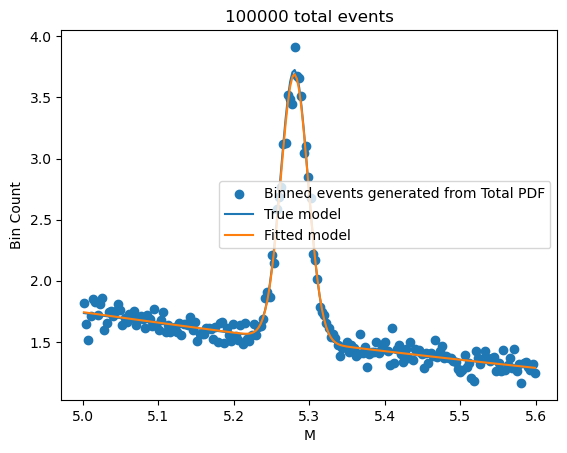

In [7]:
fig, ax = plt.subplots()

# Plotting bin count vs midpoints
ax.scatter(midpoints, bin_counts, label='Binned events generated from Total PDF', marker='o')
ax.plot(midpoints, model(midpoints, **true_params), label='True model')
ax.plot(midpoints, model(midpoints, *mi.values), label='Fitted model')

ax.set_xlabel('M')
ax.set_ylabel('Bin Count')
ax.set_title(f'{N_events} total events')

ax.legend()

The cdf of the total PDF is given by the function defined below. In the report I will definitely have to justify this:

In [8]:
def total_cdf(M, f, lam, mu, sigma):
    alpha = 5
    beta = 5.6

    A = 1/(norm.cdf(x=beta, loc=mu, scale=sigma) - norm.cdf(x=alpha, loc=mu, scale=sigma))

    B = 1/(expon.cdf(x=beta, scale=1/lam) - expon.cdf(x=alpha, scale=1/lam))

    signal_cdf = A*(norm.cdf(x=M, loc=mu, scale=sigma) - norm.cdf(x=alpha, loc=mu, scale=sigma))
    background_cdf = B*(expon.cdf(x=M, scale=1/lam) - expon.cdf(x=alpha, scale=1/lam))

    return f*signal_cdf + (1-f)*background_cdf

In [9]:
binned_nll = BinnedNLL(bin_counts, bin_edges, total_cdf)
binned_mi = Minuit(
    fcn = binned_nll,
    f = 0.1,
    lam = 0.5,
    mu = 5.28,
    sigma = 0.018,
)

start = process_time()
binned_mi.migrad()
binned_mi.hesse()
binned_mi.minos()
stop = process_time()

print ( " ++++ BINNED ++++ " )
print ( binned_mi.params )
print ( f" Took { stop - start :5.3} seconds ")

 ++++ BINNED ++++ 
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ f     │   0.098   │   0.028   │   -0.027   │   0.030    │         │         │       │
│ 1 │ lam   │   0.51    │   0.33    │   -0.33    │    0.33    │         │         │       │
│ 2 │ mu    │   5.280   │   0.006   │   -0.006   │   0.006    │         │         │       │
│ 3 │ sigma │   0.018   │   0.006   │   -0.005   │   0.007    │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
 Took 0.112 seconds 


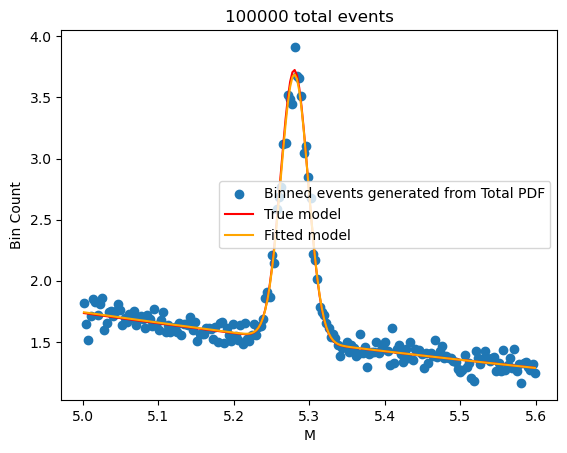

In [10]:
fig, ax = plt.subplots()

# Plotting bin count vs midpoints
ax.scatter(midpoints, bin_counts, label='Binned events generated from Total PDF', marker='o')
ax.plot(midpoints, model(midpoints, **true_params), label='True model', color='red')
ax.plot(midpoints, model(midpoints, *binned_mi.values), label='Fitted model', color='orange')

ax.set_xlabel('M')
ax.set_ylabel('Bin Count')
ax.set_title(f'{N_events} total events')

ax.legend()